# About this Notebook

Bayesian temporal matrix factorization is a type of Bayesian matrix factorization that achieves state-of-the-art results on challenging imputation and prediction problems. In the following, we will discuss:

- What the proposed Bayesian temporal matrix factorization (BTMF for short) is?

- How to implement BTMF mainly using Python `Numpy` with high efficiency?

- How to develop a spatiotemporal prediction model by adapting BTMF?

- How to make predictions with real-world spatiotemporal datasets?

If you want to understand what is BTMF and its modeling tricks in detail, our paper is for you:

> Xinyu Chen, Lijun Sun (2019). **Bayesian temporal factorization for multidimensional time series prediction**.

## Quick Run

This notebook is publicly available for any usage at our data imputation project. Please click [**transdim**](https://github.com/xinychen/transdim).


In [1]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import inv as inv

# Part 1: Matrix Computation Concepts

## 1) Kronecker product

- **Definition**:

Given two matrices $A\in\mathbb{R}^{m_1\times n_1}$ and $B\in\mathbb{R}^{m_2\times n_2}$, then, the **Kronecker product** between these two matrices is defined as

$$A\otimes B=\left[ \begin{array}{cccc} a_{11}B & a_{12}B & \cdots & a_{1m_2}B \\ a_{21}B & a_{22}B & \cdots & a_{2m_2}B \\ \vdots & \vdots & \ddots & \vdots \\ a_{m_11}B & a_{m_12}B & \cdots & a_{m_1m_2}B \\ \end{array} \right]$$
where the symbol $\otimes$ denotes Kronecker product, and the size of resulted $A\otimes B$ is $(m_1m_2)\times (n_1n_2)$ (i.e., $m_1\times m_2$ columns and $n_1\times n_2$ rows).

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]$ and $B=\left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10 \\ \end{array} \right]$, then, we have

$$A\otimes B=\left[ \begin{array}{cc} 1\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 2\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ 3\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 4\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cccccc} 5 & 6 & 7 & 10 & 12 & 14 \\ 8 & 9 & 10 & 16 & 18 & 20 \\ 15 & 18 & 21 & 20 & 24 & 28 \\ 24 & 27 & 30 & 32 & 36 & 40 \\ \end{array} \right]\in\mathbb{R}^{4\times 6}.$$

## 2) Khatri-Rao product (`kr_prod`)

- **Definition**:

Given two matrices $A=\left( \boldsymbol{a}_1,\boldsymbol{a}_2,...,\boldsymbol{a}_r \right)\in\mathbb{R}^{m\times r}$ and $B=\left( \boldsymbol{b}_1,\boldsymbol{b}_2,...,\boldsymbol{b}_r \right)\in\mathbb{R}^{n\times r}$ with same number of columns, then, the **Khatri-Rao product** (or **column-wise Kronecker product**) between $A$ and $B$ is given as follows,

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2,...,\boldsymbol{a}_r\otimes \boldsymbol{b}_r \right)\in\mathbb{R}^{(mn)\times r}$$
where the symbol $\odot$ denotes Khatri-Rao product, and $\otimes$ denotes Kronecker product.

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]=\left( \boldsymbol{a}_1,\boldsymbol{a}_2 \right) $ and $B=\left[ \begin{array}{cc} 5 & 6 \\ 7 & 8 \\ 9 & 10 \\ \end{array} \right]=\left( \boldsymbol{b}_1,\boldsymbol{b}_2 \right) $, then, we have

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2 \right) $$

$$=\left[ \begin{array}{cc} \left[ \begin{array}{c} 1 \\ 3 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 5 \\ 7 \\ 9 \\ \end{array} \right] & \left[ \begin{array}{c} 2 \\ 4 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 6 \\ 8 \\ 10 \\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cc} 5 & 12 \\ 7 & 16 \\ 9 & 20 \\ 15 & 24 \\ 21 & 32 \\ 27 & 40 \\ \end{array} \right]\in\mathbb{R}^{6\times 2}.$$

In [2]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

In [3]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8], [9, 10]])
print(kr_prod(A, B))

[[ 5 12]
 [ 7 16]
 [ 9 20]
 [15 24]
 [21 32]
 [27 40]]


## 3) Computing Covariance Matrix (`cov_mat`)

For any matrix $X\in\mathbb{R}^{m\times n}$, `cov_mat` can return a $n\times n$ covariance matrix for special use in the following.

In [4]:
def cov_mat(mat):
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim2, dim2))
    mat_bar = np.mean(mat, axis = 0)
    for i in range(dim1):
        new_mat += np.einsum('i, j -> ij', mat[i, :] - mat_bar, mat[i, :] - mat_bar)
    return new_mat

## 4) Tensor Unfolding (`ten2mat`) and Matrix Folding (`mat2ten`)

Using numpy reshape to perform 3rd rank tensor unfold operation. [[**link**](https://stackoverflow.com/questions/49970141/using-numpy-reshape-to-perform-3rd-rank-tensor-unfold-operation)]

In [5]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [6]:
X = np.array([[[1, 2, 3, 4], [3, 4, 5, 6]], 
              [[5, 6, 7, 8], [7, 8, 9, 10]], 
              [[9, 10, 11, 12], [11, 12, 13, 14]]])
print('tensor size:')
print(X.shape)
print('original tensor:')
print(X)
print()
print('(1) mode-1 tensor unfolding:')
print(ten2mat(X, 0))
print()
print('(2) mode-2 tensor unfolding:')
print(ten2mat(X, 1))
print()
print('(3) mode-3 tensor unfolding:')
print(ten2mat(X, 2))

tensor size:
(3, 2, 4)
original tensor:
[[[ 1  2  3  4]
  [ 3  4  5  6]]

 [[ 5  6  7  8]
  [ 7  8  9 10]]

 [[ 9 10 11 12]
  [11 12 13 14]]]

(1) mode-1 tensor unfolding:
[[ 1  3  2  4  3  5  4  6]
 [ 5  7  6  8  7  9  8 10]
 [ 9 11 10 12 11 13 12 14]]

(2) mode-2 tensor unfolding:
[[ 1  5  9  2  6 10  3  7 11  4  8 12]
 [ 3  7 11  4  8 12  5  9 13  6 10 14]]

(3) mode-3 tensor unfolding:
[[ 1  5  9  3  7 11]
 [ 2  6 10  4  8 12]
 [ 3  7 11  5  9 13]
 [ 4  8 12  6 10 14]]


In [7]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

## 5) Generating Matrix Normal Distributed Random Matrix

In [8]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.rand(dim1, dim2)
    P = np.linalg.cholesky(U)
    Q = np.linalg.cholesky(V)
    return M + np.matmul(np.matmul(P, X0), Q.T)

# Part 2: Bayesian Temporal Matrix Factorization (BTMF)

In [9]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, maxiter1, maxiter2):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    W = init["W"]
    X = init["X"]
    
    d = time_lags.shape[0]
    dim1, dim2 = sparse_mat.shape
    pos = np.where((dense_mat != 0) & (sparse_mat == 0))
    position = np.where(sparse_mat != 0)
    binary_mat = np.zeros((dim1, dim2))
    binary_mat[position] = 1
    
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    tau = 1
    alpha = 1e-6
    beta = 1e-6
    S0 = np.eye(rank)
    Psi0 = np.eye(rank * d)
    M0 = np.zeros((rank * d, rank))
    
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    X_new_plus = np.zeros((dim2 + 1, rank))
    A_plus = np.zeros((rank, rank, d))
    mat_hat_plus = np.zeros((dim1, dim2 + 1))
    for iters in range(maxiter1):
        W_bar = np.mean(W, axis = 0)
        var_mu_hyper = (dim1 * W_bar)/(dim1 + beta0)
        var_W_hyper = inv(inv(W0) + cov_mat(W) + dim1 * beta0/(dim1 + beta0) * np.outer(W_bar, W_bar))
        var_Lambda_hyper = wishart(df = dim1 + nu0, scale = var_W_hyper, seed = None).rvs()
        var_mu_hyper = mvnrnd(var_mu_hyper, inv((dim1 + beta0) * var_Lambda_hyper))
        
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat.T).reshape([rank, rank, dim1]) + np.dstack([var_Lambda_hyper] * dim1)
        var4 = (tau * np.matmul(var1, sparse_mat.T)
                + np.dstack([np.matmul(var_Lambda_hyper, var_mu_hyper)] * dim1)[0, :, :])
        for i in range(dim1):
            inv_var_Lambda = inv(var3[:, :, i])
            W[i, :] = mvnrnd(np.matmul(inv_var_Lambda, var4[:, i]), inv_var_Lambda)
        if iters + 1 > maxiter1 - maxiter2:
            W_plus += W
        
        Z_mat0 = X[0 : np.max(time_lags), :]
        Z_mat = X[np.max(time_lags) : dim2, :]
        Q_mat = np.zeros((dim2 - np.max(time_lags), rank * d))
        for t in range(np.max(time_lags), dim2):
            Q_mat[t - np.max(time_lags), :] = X[t - time_lags, :].reshape([rank * d])
        var_Psi = inv(inv(Psi0) + np.matmul(Q_mat.T, Q_mat))
        var_M = np.matmul(var_Psi, np.matmul(inv(Psi0), M0) + np.matmul(Q_mat.T, Z_mat))
        var_S = (S0 + np.matmul(Z_mat.T, Z_mat) + np.matmul(np.matmul(M0.T, inv(Psi0)), M0) 
                 - np.matmul(np.matmul(var_M.T, inv(var_Psi)), var_M))
        Sigma = invwishart(df = nu0 + dim2 - np.max(time_lags), scale = var_S, seed = None).rvs()
        Lambda_x = inv(Sigma)
        A = mat2ten(mnrnd(var_M, var_Psi, Sigma).T, np.array([rank, rank, d]), 0)
        if iters + 1 > maxiter1 - maxiter2:
            A_plus += A

        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat).reshape([rank, rank, dim2]) + np.dstack([Lambda_x] * dim2)
        var4 = tau * np.matmul(var1, sparse_mat)
        for t in range(dim2):
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t < np.max(time_lags):
                Qt = np.zeros(rank)
            else:
                Qt = np.matmul(Lambda_x, np.matmul(ten2mat(A, 0), X[t - time_lags, :].reshape([rank * d])))
            if t < dim2 - np.min(time_lags):
                if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags >= np.max(time_lags)) & (t + time_lags < dim2)))[0]
                for k in index:
                    Ak = A[:, :, k]
                    Mt += np.matmul(np.matmul(Ak.T, Lambda_x), Ak)
                    A0 = A.copy()
                    A0[:, :, k] = 0
                    var5 = (X[t + time_lags[k], :] 
                            - np.matmul(ten2mat(A0, 0), X[t + time_lags[k] - time_lags, :].reshape([rank * d])))
                    Nt += np.matmul(np.matmul(Ak.T, Lambda_x), var5)
            var_mu = var4[:, t] + Nt + Qt
            if t < np.max(time_lags):
                inv_var_Lambda = inv(var3[:, :, t] + Mt - Lambda_x + np.eye(rank))
            else:
                inv_var_Lambda = inv(var3[:, :, t] + Mt)
            X[t, :] = mvnrnd(np.matmul(inv_var_Lambda, var_mu), inv_var_Lambda)
        mat_hat = np.matmul(W, X.T)
        
        X_new = np.zeros((dim2 + 1, rank))
        if iters + 1 > maxiter1 - maxiter2:
            X_new[0 : dim2, :] = X.copy()
            X_new[dim2, :] = np.matmul(ten2mat(A, 0), X_new[dim2 - time_lags, :].reshape([rank * d]))
            X_new_plus += X_new
            mat_hat_plus += np.matmul(W, X_new.T)
        
        tau = np.random.gamma(alpha + 0.5 * sparse_mat[position].shape[0], 
                              1/(beta + 0.5 * np.sum((sparse_mat - mat_hat)[position] ** 2)))
        rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2)/dense_mat[pos].shape[0])
        if (iters + 1) % 200 == 0 and iters < maxiter1 - maxiter2:
            print('Iter: {}'.format(iters + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()

    W = W_plus/maxiter2
    X_new = X_new_plus/maxiter2
    A = A_plus/maxiter2
    mat_hat = mat_hat_plus/maxiter2
    if maxiter1 >= 100:
        final_mape = np.sum(np.abs(dense_mat[pos] - mat_hat[pos])/dense_mat[pos])/dense_mat[pos].shape[0]
        final_rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2)/dense_mat[pos].shape[0])
        print('Imputation MAPE: {:.6}'.format(final_mape))
        print('Imputation RMSE: {:.6}'.format(final_rmse))
        print()
    
    return mat_hat, W, X_new, A

In [10]:
def OnlineBTMF(sparse_vec, init, time_lags, maxiter1, maxiter2):
    """Online Bayesain Temporal Matrix Factorization"""
    W = init["W"]
    X = init["X"]
    A = init["A"]

    d = time_lags.shape[0]
    dim = sparse_vec.shape[0]
    t, rank = X.shape
    position = np.where(sparse_vec != 0)
    binary_vec = np.zeros(dim)
    binary_vec[position] = 1

    tau = 1
    alpha = 1e-6
    beta = 1e-6
    nu0 = rank
    W0 = np.eye(rank)
    var_mu0 = np.matmul(ten2mat(A, 0), X[t - 1 - time_lags, :].reshape([rank * d]))

    X_new_plus = np.zeros((t + 1, rank))
    mat_hat_plus = np.zeros((W.shape[0], t + 1))
    for iters in range(maxiter1):
        vec0 = X[t - 1, :] - var_mu0
        Lambda_x = wishart(df = nu0 + 1, scale = inv(inv(W0) + np.outer(vec0, vec0)), seed = None).rvs()
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var_mu = tau * np.matmul(var1, sparse_vec) + np.matmul(Lambda_x, var_mu0)
        inv_var_Lambda = inv(tau * np.matmul(var2, binary_vec).reshape([rank, rank]) + Lambda_x)
        X[t - 1, :] = mvnrnd(np.matmul(inv_var_Lambda, var_mu), inv_var_Lambda)
        
        tau = np.random.gamma(alpha + 0.5 * sparse_vec[position].shape[0], 
                              1/(beta + 0.5 * np.sum((sparse_vec - np.matmul(W, X[t - 1, :]))[position] ** 2)))
        
        X_new = np.zeros((t + 1, rank))
        if iters + 1 > maxiter1 - maxiter2:
            X_new[0 : t, :] = X.copy()
            X_new[t, :] = np.matmul(ten2mat(A, 0), X_new[t - time_lags, :].reshape([rank * d]))
            X_new_plus += X_new
            mat_hat_plus += np.matmul(W, X_new.T)

    X_new = X_new_plus/maxiter2
    mat_hat = mat_hat_plus/maxiter2
    return mat_hat, X_new

In [11]:
def st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter):
    T = dense_mat.shape[1]
    start_time = T - pred_time_steps
    dense_mat0 = dense_mat[:, 0 : start_time]
    sparse_mat0 = sparse_mat[:, 0 : start_time]
    dim1, dim2 = sparse_mat0.shape
    d = time_lags.shape[0]
    mat_hat = np.zeros((dim1, pred_time_steps))
    
    for t in range(pred_time_steps):
        if t == 0:
            init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
            mat, W, X, A = BTMF(dense_mat0, sparse_mat0, init, rank, time_lags, maxiter[0], maxiter[1])
        else:
            sparse_vec = sparse_mat[:, start_time + t - 1]
            if np.where(sparse_vec != 0)[0].shape[0] > rank:
                init = {"W": W, "X": X[- np.max(time_lags) :, :], "A": A}
                mat, X = OnlineBTMF(sparse_vec, init, time_lags, maxiter[2], maxiter[3])
            else:
                X0 = np.zeros((np.max(time_lags) + 1, rank))
                X0[: -1, :] = X[- np.max(time_lags) :, :]
                X0[-1, :] = np.matmul(ten2mat(A, 0), X[-1 - time_lags, :].reshape([rank * d]))
                X = X0.copy()
                mat = np.matmul(W, X.T)
        mat_hat[:, t] = mat[:, -1]
        if (t + 1) % 40 == 0:
            print('Time step: {}'.format(t + 1))

    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat != 0)
    final_mape = np.sum(np.abs(small_dense_mat[pos] - 
                               mat_hat[pos])/small_dense_mat[pos])/small_dense_mat[pos].shape[0]
    final_rmse = np.sqrt(np.sum((small_dense_mat[pos] - 
                                 mat_hat[pos]) ** 2)/small_dense_mat[pos].shape[0])
    print('Final MAPE: {:.6}'.format(final_mape))
    print('Final RMSE: {:.6}'.format(final_rmse))
    print()
    return mat_hat

# Part 3: Data Organization

## 1) Matrix Structure

We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{f},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We express spatio-temporal dataset as a matrix $Y\in\mathbb{R}^{m\times f}$ with $m$ rows (e.g., locations) and $f$ columns (e.g., discrete time intervals),

$$Y=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{m1} & y_{m2} & \cdots & y_{mf} \\ \end{array} \right]\in\mathbb{R}^{m\times f}.$$

## 2) Tensor Structure

We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{nf},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We partition each time series into intervals of predifined length $f$. We express each partitioned time series as a matrix $Y_{i}$ with $n$ rows (e.g., days) and $f$ columns (e.g., discrete time intervals per day),

$$Y_{i}=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{n1} & y_{n2} & \cdots & y_{nf} \\ \end{array} \right]\in\mathbb{R}^{n\times f},i=1,2,...,m,$$

therefore, the resulting structure is a tensor $\mathcal{Y}\in\mathbb{R}^{m\times n\times f}$.

# Part 4: Experiments on Guangzhou Data Set

In [24]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.2

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [25]:
import time
start = time.time()
pred_time_steps = 144 * 5
rank = 30
time_lags = np.array([1, 2, 144])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0856336
Imputation RMSE: 3.63864

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Final MAPE: 0.10451
Final RMSE: 4.17393

Running time: 2095 seconds


In [28]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.0

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [29]:
import time
start = time.time()
pred_time_steps = 144 * 5
rank = 30
time_lags = np.array([1, 2, 144])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


Imputation MAPE: nan
Imputation RMSE: nan

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Final MAPE: 0.102503
Final RMSE: 4.09247

Running time: 2019 seconds


In [26]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [27]:
import time
start = time.time()
pred_time_steps = 144 * 5
rank = 30
time_lags = np.array([1, 2, 144])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0864591
Imputation RMSE: 3.69145

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Final MAPE: 0.107804
Final RMSE: 4.31435

Running time: 1894 seconds


In [16]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.2

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] 
                                    * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [18]:
import time
start = time.time()
pred_time_steps = 144 * 5
rank = 30
time_lags = np.array([1, 2, 144])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.10311
Imputation RMSE: 4.63283

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Final MAPE: 0.106683
Final RMSE: 4.26517

Running time: 2483 seconds


In [30]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] 
                                    * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [31]:
import time
start = time.time()
pred_time_steps = 144 * 5
rank = 30
time_lags = np.array([1, 2, 144])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.110575
Imputation RMSE: 5.0134

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Final MAPE: 0.113245
Final RMSE: 4.59381

Running time: 2203 seconds


### Visualizing Time Series Data

In [32]:
small_sparse_mat = sparse_mat[:, sparse_mat.shape[1] - pred_time_steps : sparse_mat.shape[1]]
road = np.array([0, 1, 2, 50, 51, 52, 100, 101, 102])
data = np.zeros((3 * road.shape[0], pred_time_steps))
for i in range(road.shape[0]):
    data[3 * i, :] = small_dense_mat[road[i], :]
    data[3 * i + 1, :] = small_sparse_mat[road[i], :]
    data[3 * i + 2, :] = mat_hat[road[i], :]

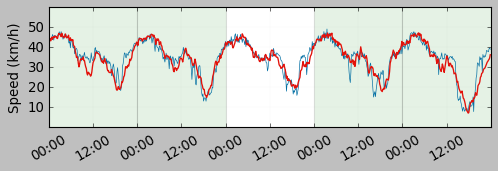

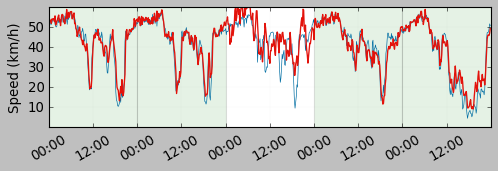

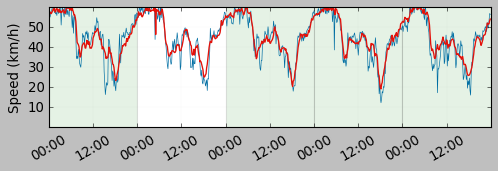

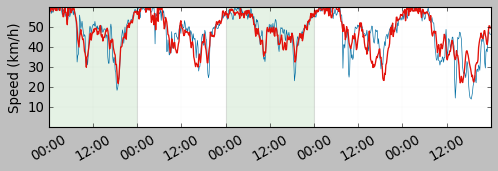

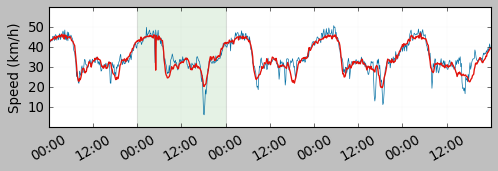

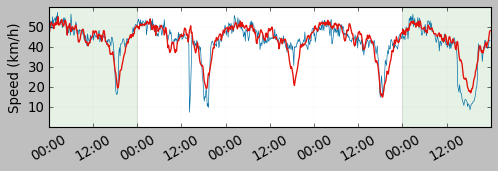

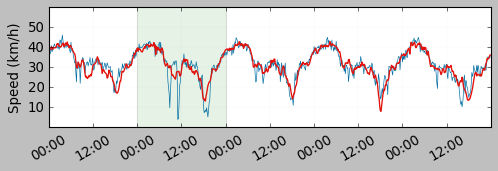

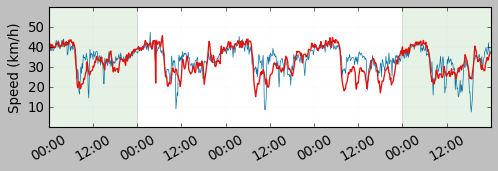

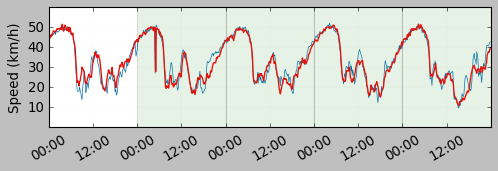

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
for i in range(road.shape[0]):
    plt.style.use('classic')
    fig = plt.figure(figsize=(4.25, 1.55))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(data[3 * i, :], color = "#006ea3", linewidth = 1.0, label = "Actual value")
    plt.plot(data[3 * i + 2, :], color = "#e3120b", linewidth = 1.2, label = "Predicted value")
    ax.set_xlim([0, pred_time_steps])
    ax.set_ylim([0, 60])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
    for j in range(5):
        if data[3 * i + 1, 144 * j] > 0:
            someX, someY = j * 144, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 144, 60, alpha = 0.1, facecolor = 'green'))

    plt.xticks(np.arange(0, 5*144, 72),["00:00", "12:00", "00:00", "12:00",
                        "00:00", "12:00", "00:00", "12:00", "00:00", "12:00"], rotation = 30, **axis_font)
    plt.yticks(np.arange(10, 60, 20), [10, 30, 50], **axis_font)
    ax.set_ylabel("Speed (km/h)", **axis_font)
    plt.show()
    fig.savefig("../images/time_series_speed_{}.pdf".format(road[i] + 1))

**Experiment results** of short-term rolling prediction with missing values using BTMF:

|  scenario |`rank`|`time_lags`| `maxiter` |       mape |      rmse |
|:----------|-----:|---------:|---------:|-----------:|----------:|
|**Original data**| 30 | (1,2,144) | (200,100,1100,100) | **0.1025** | **4.09**|
|**20%, RM**| 30 | (1,2,144) | (200,100,1100,100) | **0.1045** | **4.17**|
|**40%, RM**| 30 | (1,2,144) | (200,100,1100,100) | **0.1078** | **4.31**|
|**20%, NM**| 30 | (1,2,144) | (200,100,1100,100) | **0.1067** | **4.27**|
|**40%, NM**| 30 | (1,2,144) | (200,100,1100,100) | **0.1132** | **4.59**|


# Part 5: Experiments on Birmingham Data Set

In [35]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.1

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [36]:
import time
start = time.time()
pred_time_steps = 18 * 7
rank = 10
time_lags = np.array([1, 2, 18])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0804938
Imputation RMSE: 21.1973

Time step: 40
Time step: 80
Time step: 120
Final MAPE: 0.235541
Final RMSE: 127.446

Running time: 184 seconds


In [37]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.3

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [38]:
import time
start = time.time()
pred_time_steps = 18 * 7
rank = 10
time_lags = np.array([1, 2, 18])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0811636
Imputation RMSE: 27.5325

Time step: 40
Time step: 80
Time step: 120
Final MAPE: 0.227866
Final RMSE: 131.603

Running time: 179 seconds


In [39]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.1

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [40]:
import time
start = time.time()
pred_time_steps = 18 * 7
rank = 10
time_lags = np.array([1, 2, 18])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.121692
Imputation RMSE: 27.7036

Time step: 40
Time step: 80
Time step: 120
Final MAPE: 0.242847
Final RMSE: 142.452

Running time: 171 seconds


In [43]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.0

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [44]:
import time
start = time.time()
pred_time_steps = 18 * 7
rank = 10
time_lags = np.array([1, 2, 18])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


Imputation MAPE: nan
Imputation RMSE: nan

Time step: 40
Time step: 80
Time step: 120
Final MAPE: 0.251043
Final RMSE: 155.318

Running time: 173 seconds


In [74]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.3

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [75]:
import time
start = time.time()
pred_time_steps = 18 * 7
rank = 10
time_lags = np.array([1, 2, 18])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.148622
Imputation RMSE: 58.9851

Time step: 40
Time step: 80
Time step: 120
Final MAPE: 0.236025
Final RMSE: 138.132

Running time: 169 seconds


### Visualizing Time Series Data

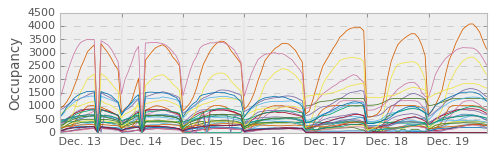

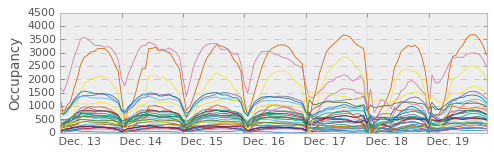

In [78]:
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(5.4, 1.5))
ax = fig.add_axes([0.16, 0.14, 0.80, 0.82])
ax.tick_params(direction = 'in')
plt.plot(small_dense_mat.T, linewidth = 0.7)
ax.set_xlim([0, 18 * 7 - 1])
ax.set_ylim([0, 4500])
ax.set_ylabel("Occupancy")
ax.grid(linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.xticks(np.arange(0, 7 * 18, 18), [1, 1*18+1, 2*18+1, 3*18+1, 4*18+1, 5*18+1, 6*18+1])
plt.xticks(np.arange(0, 7 * 18, 18), ["           Dec.13", "           Dec.14", "           Dec.15", 
                                      "           Dec.16", "           Dec.17", "           Dec.18", 
                                      "           Dec.19"])
plt.yticks(np.arange(0, 4500, 1000), [0, 1000, 2000, 3000, 4000])
plt.show()
fig.savefig("../images/Bdata_actual_values_30NM.pdf")

fig = plt.figure(figsize=(5.4, 1.5))
ax = fig.add_axes([0.16, 0.14, 0.80, 0.82])
ax.tick_params(direction = 'in')
plt.plot(mat_hat.T, linewidth = 0.7)
ax.set_xlim([0, 18 * 7 - 1])
ax.set_ylim([0, 4500])
ax.set_ylabel("Occupancy")
ax.grid(linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.xticks(np.arange(0, 7 * 18, 18), [1, 1*18+1, 2*18+1, 3*18+1, 4*18+1, 5*18+1, 6*18+1])
plt.xticks(np.arange(0, 7 * 18, 18), ["           Dec.13", "           Dec.14", "           Dec.15", 
                                      "           Dec.16", "           Dec.17", "           Dec.18", 
                                      "           Dec.19"])
plt.yticks(np.arange(0, 4500, 1000), [0, 1000, 2000, 3000, 4000])
plt.show()
fig.savefig("../images/Bdata_predicted_values_30NM.pdf")

**Experiment results** of short-term rolling prediction with missing values using BTMF:

|  scenario |`rank`|`time_lags`| `maxiter` |       mape |      rmse |
|:----------|-----:|---------:|---------:|-----------:|----------:|
|**Original data**| 10 | (1,2,18) | (200,100,1100,100) | **0.2510** | **155.32**|
|**10%, RM**| 10 | (1,2,18) | (200,100,1100,100) | **0.2355** | **127.45**|
|**30%, RM**| 10 | (1,2,18) | (200,100,1100,100) | **0.2279** | **131.60**|
|**10%, NM**| 10 | (1,2,18) | (200,100,1100,100) | **0.2428** | **142.45**|
|**30%, NM**| 10 | (1,2,18) | (200,100,1100,100) | **0.2360** | **138.12**|


# Part 6: Experiments on Hangzhou Data Set

In [60]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.0

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [61]:
import time
start = time.time()
pred_time_steps = 108 * 5
rank = 10
time_lags = np.array([1, 2, 108])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


Imputation MAPE: nan
Imputation RMSE: nan

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Final MAPE: 0.300423
Final RMSE: 37.2874

Running time: 512 seconds


In [62]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.2

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [63]:
import time
start = time.time()
pred_time_steps = 108 * 5
rank = 10
time_lags = np.array([1, 2, 108])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.234816
Imputation RMSE: 36.7882

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Final MAPE: 0.293796
Final RMSE: 38.2779

Running time: 513 seconds


In [64]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [65]:
import time
start = time.time()
pred_time_steps = 108 * 5
rank = 10
time_lags = np.array([1, 2, 108])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.24812
Imputation RMSE: 39.7161

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Final MAPE: 0.30493
Final RMSE: 39.9564

Running time: 523 seconds


In [66]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.2

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] 
                                    * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [67]:
import time
start = time.time()
pred_time_steps = 108 * 5
rank = 10
time_lags = np.array([1, 2, 108])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.299144
Imputation RMSE: 100.006

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Final MAPE: 0.302631
Final RMSE: 46.6178

Running time: 514 seconds


In [68]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] 
                                    * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [69]:
import time
start = time.time()
pred_time_steps = 108 * 5
rank = 10
time_lags = np.array([1, 2, 108])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.297383
Imputation RMSE: 76.1508

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Final MAPE: 0.305164
Final RMSE: 45.8866

Running time: 533 seconds


### Visualizing Time Series Data

In [70]:
small_sparse_mat = sparse_mat[:, sparse_mat.shape[1] - pred_time_steps : sparse_mat.shape[1]]
station = np.array([0, 1, 2, 30, 31, 32, 60, 61, 62])
data = np.zeros((3 * station.shape[0], pred_time_steps))
for i in range(station.shape[0]):
    data[3 * i, :] = small_dense_mat[station[i], :]
    data[3 * i + 1, :] = small_sparse_mat[station[i], :]
    data[3 * i + 2, :] = mat_hat[station[i], :]

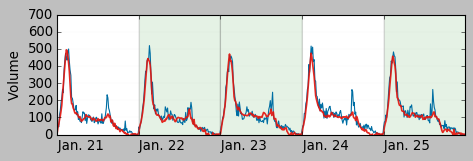

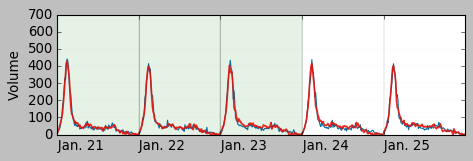

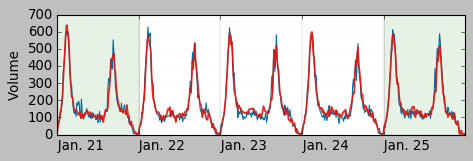

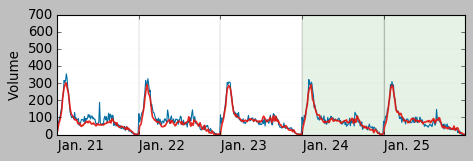

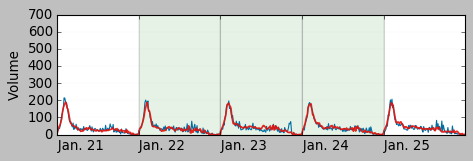

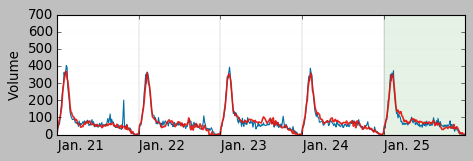

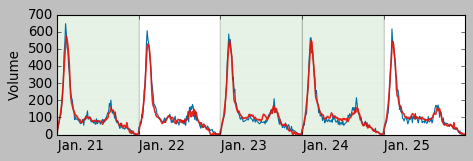

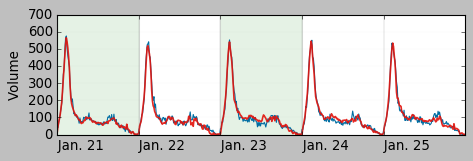

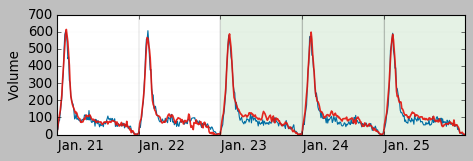

In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
for i in range(station.shape[0]):
    plt.style.use('classic')
    fig = plt.figure(figsize=(4.0, 1.2))
    ax = fig.add_axes([0.15, 0.16, 0.82, 0.80])
    plt.plot(data[3 * i, :], color = "#006ea3", linewidth = 1.2, label = "Actual value")
    plt.plot(data[3 * i + 2, :], color = "#e3120b", linewidth = 1.2, alpha = 0.9, label = "Predicted value")
    ax.set_xlim([0, pred_time_steps])
    ax.set_ylim([0, 700])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
    for j in range(5):
        if data[3 * i + 1, 108 * j] > 0:
            someX, someY = j * 108, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 108, 700, alpha = 0.1, facecolor = 'green'))

    plt.xticks(np.arange(0, 5 * 108, 108), ["           Jan. 21", "           Jan. 22", 
                                          "           Jan. 23", "           Jan. 24", 
                                          "           Jan. 25"], **axis_font)
    plt.yticks(np.arange(0, 700, 200), [0, 200, 400, 600], **axis_font)
    ax.set_ylabel("Volume", **axis_font)
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
    plt.show()
    fig.savefig("../images/H_time_series_volume_{}.pdf".format(station[i] + 1))

**Experiment results** of short-term rolling prediction with missing values using BTMF:

|  scenario |`rank`|`time_lags`| `maxiter` |       mape |      rmse |
|:----------|-----:|---------:|---------:|-----------:|----------:|
|**Original data**| 10 | (1,2,108) | (200,100,1100,100) | **0.3004** | **37.29**|
|**20%, RM**| 10 | (1,2,108) | (200,100,1100,100) | **0.2938** | **38.28**|
|**40%, RM**| 10 | (1,2,108) | (200,100,1100,100) | **0.3049** | **39.96**|
|**20%, NM**| 10 | (1,2,108) | (200,100,1100,100) | **0.3026** | **46.62**|
|**40%, NM**| 10 | (1,2,108) | (200,100,1100,100) | **0.3052** | **45.89**|


# Part 7: Experiments on Seattle Data Set

In [24]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
RM_mat = pd.read_csv('../datasets/Seattle-data-set/RM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
RM_mat = RM_mat.values

missing_rate = 0.2
# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(RM_mat + 0.5 - missing_rate)
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [25]:
import time
start = time.time()
pred_time_steps = 288 * 5
rank = 30
time_lags = np.array([1, 2, 288])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0669118
Imputation RMSE: 4.07729

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Time step: 760
Time step: 800
Time step: 840
Time step: 880
Time step: 920
Time step: 960
Time step: 1000
Time step: 1040
Time step: 1080
Time step: 1120
Time step: 1160
Time step: 1200
Time step: 1240
Time step: 1280
Time step: 1320
Time step: 1360
Time step: 1400
Time step: 1440
Final MAPE: 0.0763978
Final RMSE: 4.61363

Running time: 3090 seconds


In [28]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
RM_mat = pd.read_csv('../datasets/Seattle-data-set/RM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
RM_mat = RM_mat.values

missing_rate = 0.4
# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(RM_mat + 0.5 - missing_rate)
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [29]:
import time
start = time.time()
pred_time_steps = 288 * 5
rank = 30
time_lags = np.array([1, 2, 288])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0689283
Imputation RMSE: 4.16049

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Time step: 760
Time step: 800
Time step: 840
Time step: 880
Time step: 920
Time step: 960
Time step: 1000
Time step: 1040
Time step: 1080
Time step: 1120
Time step: 1160
Time step: 1200
Time step: 1240
Time step: 1280
Time step: 1320
Time step: 1360
Time step: 1400
Time step: 1440
Final MAPE: 0.0785426
Final RMSE: 4.72143

Running time: 3548 seconds


In [30]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
NM_mat = pd.read_csv('../datasets/Seattle-data-set/NM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
NM_mat = NM_mat.values

missing_rate = 0.2
# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros((dense_mat.shape[0], 28, 288))
for i1 in range(binary_tensor.shape[0]):
    for i2 in range(binary_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(NM_mat[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [31]:
import time
start = time.time()
pred_time_steps = 288 * 5
rank = 30
time_lags = np.array([1, 2, 288])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0818382
Imputation RMSE: 4.92505

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Time step: 760
Time step: 800
Time step: 840
Time step: 880
Time step: 920
Time step: 960
Time step: 1000
Time step: 1040
Time step: 1080
Time step: 1120
Time step: 1160
Time step: 1200
Time step: 1240
Time step: 1280
Time step: 1320
Time step: 1360
Time step: 1400
Time step: 1440
Final MAPE: 0.0768961
Final RMSE: 4.64981

Running time: 3235 seconds


In [32]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
NM_mat = pd.read_csv('../datasets/Seattle-data-set/NM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
NM_mat = NM_mat.values

missing_rate = 0.4
# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros((dense_mat.shape[0], 28, 288))
for i1 in range(binary_tensor.shape[0]):
    for i2 in range(binary_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(NM_mat[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [33]:
import time
start = time.time()
pred_time_steps = 288 * 5
rank = 30
time_lags = np.array([1, 2, 288])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0871018
Imputation RMSE: 5.29847

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Time step: 760
Time step: 800
Time step: 840
Time step: 880
Time step: 920
Time step: 960
Time step: 1000
Time step: 1040
Time step: 1080
Time step: 1120
Time step: 1160
Time step: 1200
Time step: 1240
Time step: 1280
Time step: 1320
Time step: 1360
Time step: 1400
Time step: 1440
Final MAPE: 0.0797621
Final RMSE: 4.82653

Running time: 4679 seconds


In [34]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
NM_mat = pd.read_csv('../datasets/Seattle-data-set/NM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
NM_mat = NM_mat.values

missing_rate = 0.0
# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros((dense_mat.shape[0], 28, 288))
for i1 in range(binary_tensor.shape[0]):
    for i2 in range(binary_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(NM_mat[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [35]:
import time
start = time.time()
pred_time_steps = 288 * 5
rank = 30
time_lags = np.array([1, 2, 288])
maxiter = np.array([200, 100, 1100, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars


Imputation MAPE: nan
Imputation RMSE: nan

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Time step: 560
Time step: 600
Time step: 640
Time step: 680
Time step: 720
Time step: 760
Time step: 800
Time step: 840
Time step: 880
Time step: 920
Time step: 960
Time step: 1000
Time step: 1040
Time step: 1080
Time step: 1120
Time step: 1160
Time step: 1200
Time step: 1240
Time step: 1280
Time step: 1320
Time step: 1360
Time step: 1400
Time step: 1440
Final MAPE: 0.0747637
Final RMSE: 4.53877

Running time: 3368 seconds


**Experiment results** of short-term rolling prediction with missing values using BTMF:

|  scenario |`rank`|`time_lags`| `maxiter` |       mape |      rmse |
|:----------|-----:|---------:|---------:|-----------:|----------:|
|**Original data**| 30 | (1,2,288) | (200,100,1100,100) | **0.0748** | **4.54**|
|**20%, RM**| 30 | (1,2,288) | (200,100,1100,100) | **0.0764** | **4.61**|
|**40%, RM**| 30 | (1,2,288) | (200,100,1100,100) | **0.0785** | **4.72**|
|**20%, NM**| 30 | (1,2,108) | (200,100,1100,100) | **0.0769** | **4.65**|
|**40%, NM**| 30 | (1,2,108) | (200,100,1100,100) | **0.0798** | **4.83**|
